In [1]:
# --- 2. Imports ---

from py_gpmf_parser.gopro_telemetry_extractor import GoProTelemetryExtractor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Show plots inside notebook
%matplotlib inline

In [23]:
# --- 3. Load video and extract GPMF ---

video_path = "/home/tocisz/Wideo/Safari 2025/GX010923.MP4"   # <-- change to your file

ext = GoProTelemetryExtractor(video_path)
ext.open_source()

# Extract sensors
accl, t_accl = ext.extract_data("ACCL")   # accelerometer (x,y,z)
gyro, t_gyro = ext.extract_data("GYRO")   # gyroscope (x,y,z)
cori, t_cori = ext.extract_data("CORI")   # Format is (w, x, y, z)
iori, t_iori = ext.extract_data("IORI")   # Format is (w, x, y, z)
grav, t_grav = ext.extract_data("GRAV")   # Format is (x, y, z)

ext.close_source()

In [30]:
cori+iori

array([[ 1.99993896e+00, -7.14133122e-03,  8.54518265e-04,
         5.18814661e-04],
       [ 1.99990844e+00, -7.59910886e-03,  1.03762932e-03,
         2.13629566e-04],
       [ 1.99990844e+00, -7.99584948e-03,  1.28177740e-03,
         3.05185095e-05],
       ...,
       [ 1.85225990e+00, -4.65712455e-02,  4.78408155e-01,
        -2.11767937e-01],
       [ 1.85067293e+00, -4.68153935e-02,  4.77217933e-01,
        -2.14484085e-01],
       [ 1.85033723e+00, -4.78530229e-02,  4.74440748e-01,
        -2.20252083e-01]], shape=(661, 4))

In [3]:
# --- 4. Convert to DataFrames ---

df_accl = pd.DataFrame(accl, columns=["ax", "ay", "az"])
df_accl["t"] = t_accl

df_gyro = pd.DataFrame(gyro, columns=["gx", "gy", "gz"])
df_gyro["t"] = t_gyro

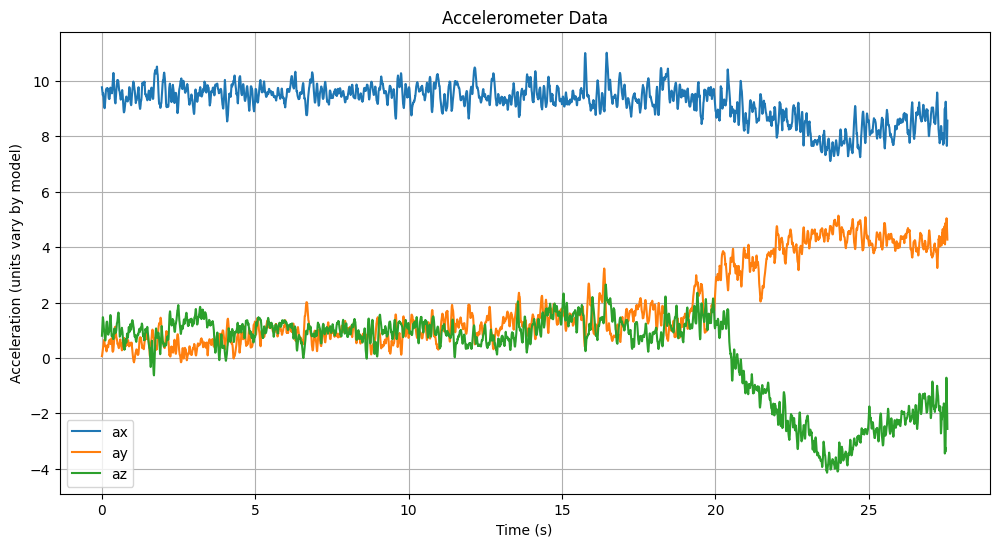

In [4]:
t_accl# --- 5. Visualize ACCELEROMETER ---

plt.figure(figsize=(12, 6))
plt.plot(df_accl["t"], df_accl["ax"], label="ax")
plt.plot(df_accl["t"], df_accl["ay"], label="ay")
plt.plot(df_accl["t"], df_accl["az"], label="az")
plt.title("Accelerometer Data")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (units vary by model)")
plt.legend()
plt.grid()
plt.show()


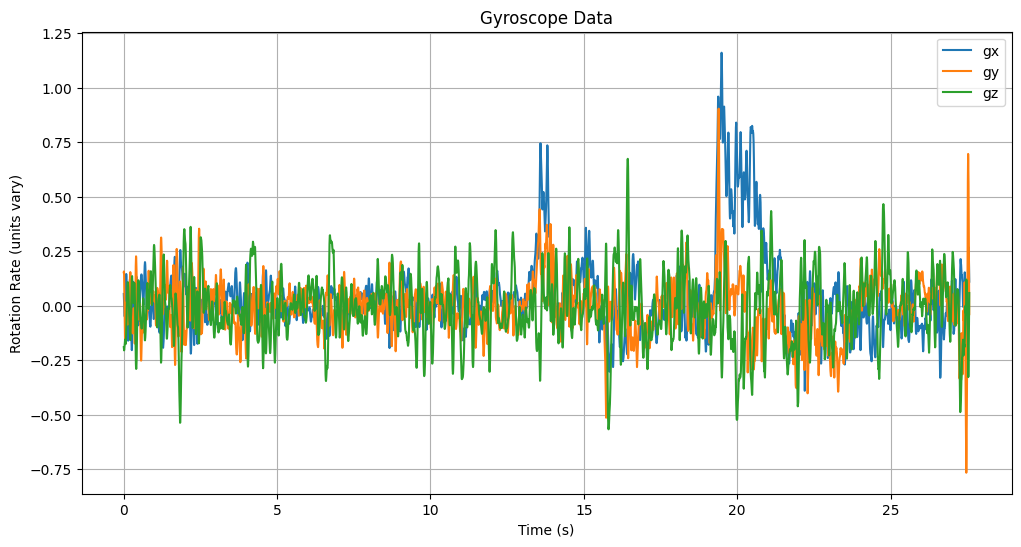

In [5]:
# --- 6. Visualize GYROSCOPE ---

plt.figure(figsize=(12, 6))
plt.plot(df_gyro["t"], df_gyro["gx"], label="gx")
plt.plot(df_gyro["t"], df_gyro["gy"], label="gy")
plt.plot(df_gyro["t"], df_gyro["gz"], label="gz")
plt.title("Gyroscope Data")
plt.xlabel("Time (s)")
plt.ylabel("Rotation Rate (units vary)")
plt.legend()
plt.grid()
plt.show()


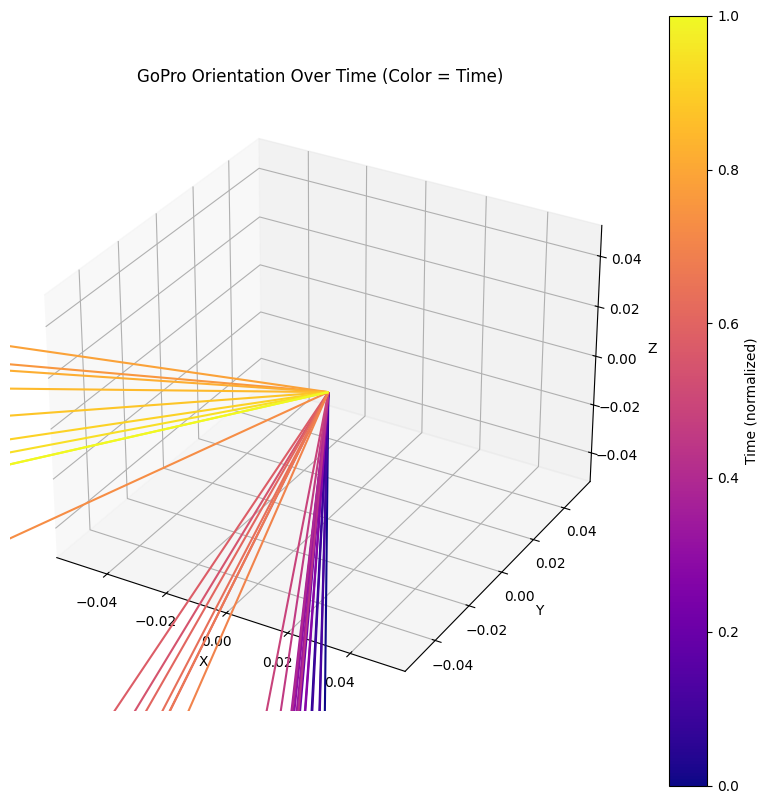

In [19]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# scipy expects (x, y, z, w)
cori_xyzw = cori[:, [1, 2, 3, 0]]

cori_rot = R.from_quat(cori_xyzw)        # full rotation object
cori_rot_mats = cori_rot.as_matrix()          # shape (N, 3, 3)
cori_forward_vectors = cori_rot_mats @ np.array([0, 0, -1.0])
# shape = (N, 3)

# forward_vectors shape: (N, 3)
# t_quat shape: (N,)  — timestamps from GPMF

step = 20  # sample rate for readability
fv = cori_forward_vectors[::step]
t = t_cori[::step]

# Normalize timestamps to [0, 1] for colormap
t_norm = (t - t.min()) / (t.max() - t.min())

# Pick a colormap (options: viridis, plasma, inferno, magma, cividis)
cmap = plt.cm.plasma
colors = cmap(t_norm)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Quiver with per-vector colors
ax.quiver(
    np.zeros(len(fv)),
    np.zeros(len(fv)),
    np.zeros(len(fv)),
    fv[:, 0], fv[:, 1], fv[:, 2],
    colors=colors,
    length=1.0,
    normalize=True
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("GoPro Orientation Over Time (Color = Time)")

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_array(t_norm)
fig.colorbar(mappable, ax=ax, label="Time (normalized)")

plt.show()
